# Analysis of Animal Shelter Data in Sonoma County, CA

## Goal of Analysis

Through our analysis, we hope to shed insight on the outcomes of animals surrendered to Sonoma County Animal Services. We primarily focused on adoption outcomes of animals.

## About the Data

We retrieved the data from SoCo Data, which is an open data portal for the County of Sonoma. Here is a link to the data: https://data.sonomacounty.ca.gov/Government/Animal-Shelter-Intake-and-Outcome/924a-vesw

In [38]:
#!pip install catboost

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sheltertools.utils import *
import random
from IPython.display import Image
random.seed(159)

In [40]:
shelter_data = pd.read_csv('./data/Animal_Shelter_Data.csv')
shelter_data.shape

(25008, 24)

In [41]:
shelter_data.head(3)

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,10/29/2009,K22-043412,TRUCK,A396382,...,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1
1,NaN,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaN,K23-044095,TRUCK,A416206,...,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,03/10/2020,K23-044090,DS80,A399488,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1


In [42]:
shelter_data.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

### Data Cleaning

In this step, we dropped all animals that had a missing size.

In [43]:
shelter_data.dropna(subset=['Size'], inplace=True)
shelter_data.isnull().sum()

Name                    6567
Type                       0
Breed                      0
Color                      0
Sex                        0
Size                       0
Date Of Birth           6206
Impound Number             0
Kennel Number             12
Animal ID                  0
Intake Date                0
Outcome Date             159
Days in Shelter            0
Intake Type                0
Intake Subtype             0
Outcome Type             165
Outcome Subtype          482
Intake Condition           0
Outcome Condition        508
Intake Jurisdiction        0
Outcome Jurisdiction    3508
Outcome Zip Code        3565
Location                3565
Count                      0
dtype: int64

## EDA

### Number of Animals in the Shelter by Type

`number_of_animals_by_type` is a function we wrote for the `sheltertools` package. It calculates the number of animals per Intake Type.

In [44]:
number_of_animals_by_type(shelter_data)

Intake Type      Type 
ADOPTION RETURN  DOG        292
                 CAT        116
                 OTHER        4
BORN HERE        CAT         16
                 OTHER        1
CONFISCATE       DOG       1456
                 CAT        245
                 OTHER      197
OS APPT          DOG          1
OWNER SURRENDER  CAT       1595
                 DOG       1414
                 OTHER      143
QUARANTINE       DOG        424
                 OTHER      277
                 CAT        118
STRAY            DOG      10223
                 CAT       6603
                 OTHER     1417
TRANSFER         DOG        258
                 CAT        161
                 OTHER       12
Name: Type, dtype: int64

### Top Breeds by Animal Type

#### Top Cat Breeds

`plot_top_breeds` is a function we wrote for the `sheltertools` package. It plots the top breeds for a specified animal type.

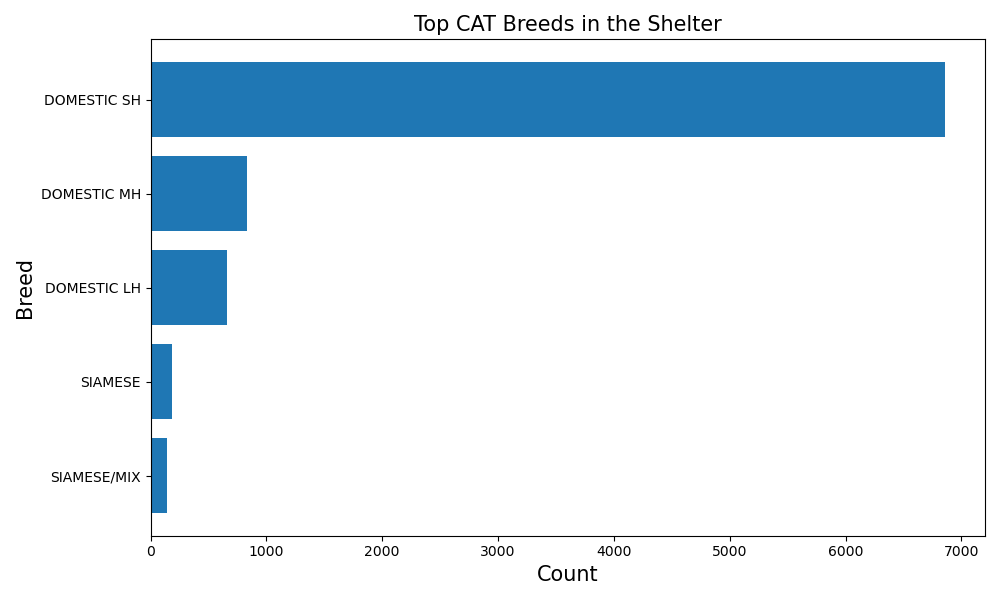

In [92]:
#plot_top_breeds('CAT', shelter_data)
Image(filename = 'figures/CAT_in_the_Shelter.png', width=800, height=800)

#### Top Dog Breeds

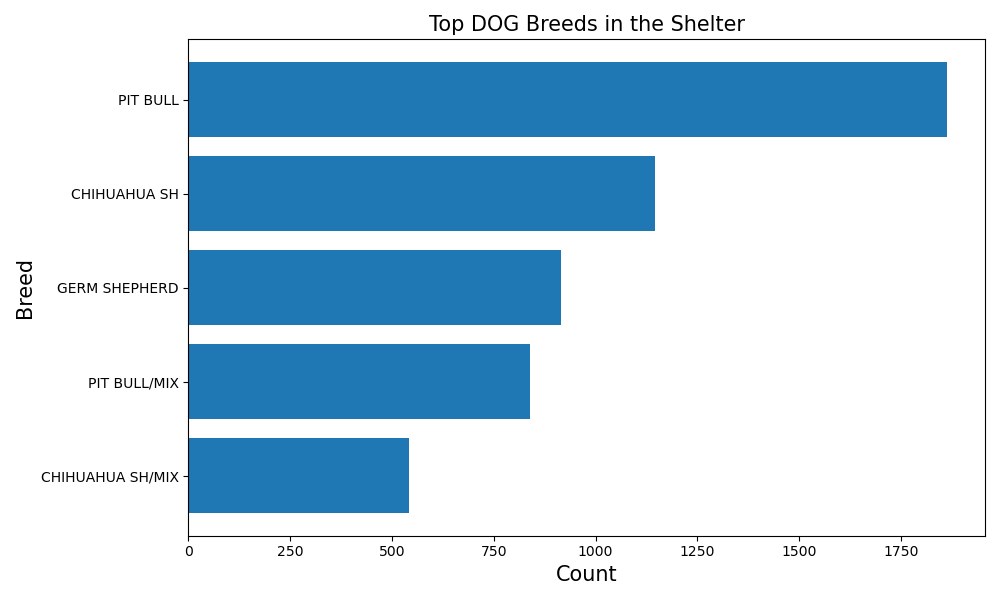

In [93]:
#plot_top_breeds('DOG', shelter_data)
Image(filename = 'figures/DOG_in_the_Shelter.png', width=800, height=800)

### Most Common Names

In [47]:
top_names = shelter_data.groupby(["Type","Name"], as_index=False).size()
top_names = top_names.sort_values(by='size', ascending=False).groupby(["Type"]).head(3)
top_names

,Type,Name,size
4614,DOG,BUDDY,131
6004,DOG,LUNA,115
4402,DOG,BELLA,104
2291,CAT,MILO,21
2197,CAT,LUCY,19
758,CAT,*LUKE,17
7727,OTHER,*JESSICA,9
7864,OTHER,*ROGER,7
8036,OTHER,OREO,5


From the table above, we can see that the top three most common names for dogs at the adoption centers are Buddy, Luna, and Bella. On the other hand, the top three most common names for adopted cats are Milo, Lucy, and Smokey.

### Trend Line: which year has the most number of animal intakes?

`plot_trend_line` is a function we wrote for the `sheltertools` package. It plots the count of animals by year.

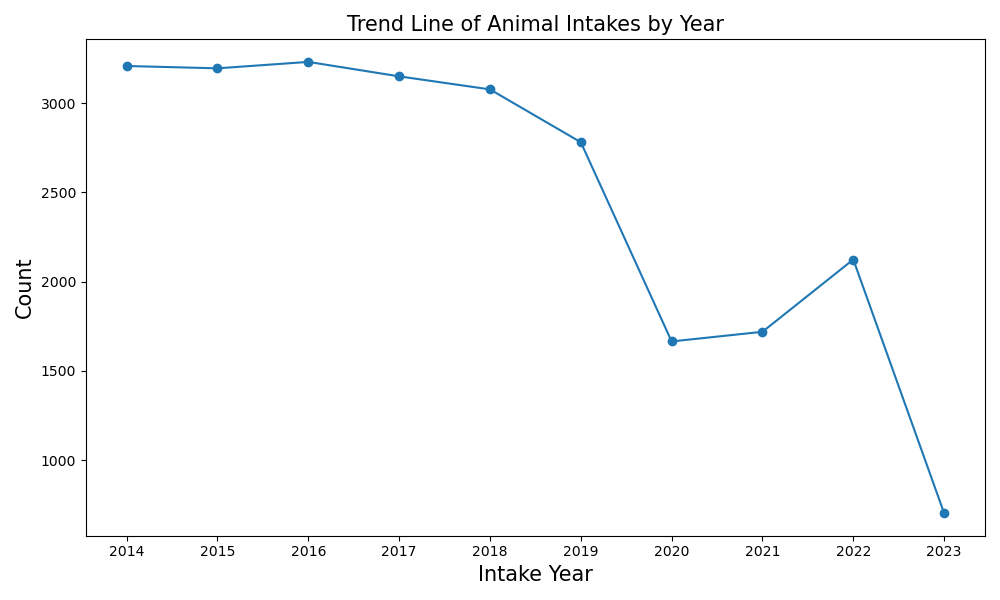

In [94]:
#plot_trend_line(shelter_data);
Image(filename = 'figures/Trend_Line_of_Animal_Intakes_by_Year.png', width=800, height=800)

### Outcomes By Species

In [49]:
# Select species and outcome type
outcome_data = shelter_data.loc[:,["Type", "Outcome Type"]]
outcome_data

,Type,Outcome Type
0,DOG,RETURN TO OWNER
1,OTHER,EUTHANIZE
2,DOG,RETURN TO OWNER
3,CAT,DISPOSAL
4,DOG,TRANSFER
...,...,...
25003,CAT,ADOPTION
25004,OTHER,TRANSFER
25005,DOG,EUTHANIZE
25006,DOG,TRANSFER


In [50]:
# Drop NA
outcome_data.dropna(subset=['Outcome Type'], inplace=True)
outcome_data.isnull().sum()

Type            0
Outcome Type    0
dtype: int64

In [51]:
# Calculate the proportion of species within each outcome type
top_outcome = outcome_data.groupby([ "Type","Outcome Type"],as_index=False).size()
top_outcome = top_outcome.groupby([ "Type","Outcome Type"], group_keys=False).agg({"size":"sum"}).groupby(
    level=0,group_keys=False).apply(lambda x: 100*x/x.sum()).sort_values(
    by=["Type","size", "Outcome Type"], ascending=[False, False, True])
top_outcome =top_outcome.rename(columns={"size":"percent"})
top_outcome

percent
Type  Outcome Type              
OTHER TRANSFER         42.793682
      EUTHANIZE        21.816387
      ADOPTION         21.273445
      RETURN TO OWNER   9.871668
      DIED              2.270484
      DISPOSAL          1.727542
      ESCAPED/STOLEN    0.246792
DOG   RETURN TO OWNER  50.250609
      ADOPTION         23.600172
      TRANSFER         14.556781
      EUTHANIZE        10.826292
      RTOS              0.264929
      DISPOSAL          0.250609
      DIED              0.214807
      ESCAPED/STOLEN    0.035801
CAT   ADOPTION         40.948276
      TRANSFER         26.576679
      EUTHANIZE        16.254537
      RETURN TO OWNER  13.214610
      DISPOSAL          1.780853
      DIED              1.020871
      RTOS              0.124773
      ESCAPED/STOLEN    0.079401

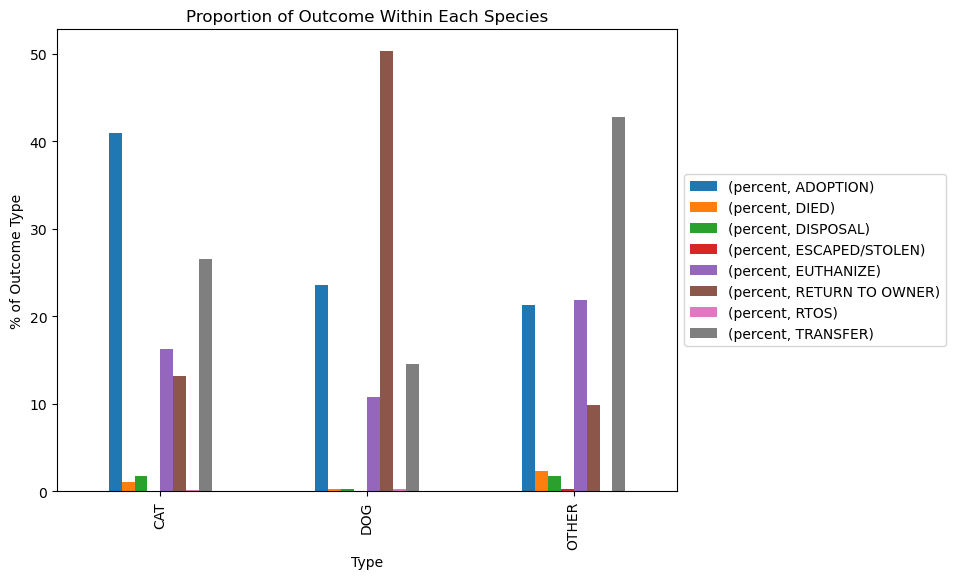

In [52]:
# Create bar plot to visualize most common outcome type within each species
ax = top_outcome.pivot_table(index="Type", columns="Outcome Type").plot(kind='bar')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("% of Outcome Type")
ax.set_title("Proportion of Outcome Within Each Species");
fig = ax.get_figure()
fig.set_size_inches(8, 6) 
fig.savefig('figures/' + 'Proportion_of_Outcome_Within_Each_Species', bbox_inches='tight')

Adoption was the most common outcome for cats at 41%. Half of the dogs in the shelter are being returned to owner, whereas most of the other species (43%) are being transferred. 

### Shelter Performance

In this section, we analyze shelter performance based on Adoption rate, Transfer rate, Return-to-owner rate, and Euthanasia Rate.

In [53]:
# Display the overall rates for each species and outcome type throughout all years
rates_df = top_outcome.pivot_table(index="Type", columns="Outcome Type")
rates_df

percent                                                \
Outcome Type   ADOPTION      DIED  DISPOSAL ESCAPED/STOLEN  EUTHANIZE   
Type                                                                    
CAT           40.948276  1.020871  1.780853       0.079401  16.254537   
DOG           23.600172  0.214807  0.250609       0.035801  10.826292   
OTHER         21.273445  2.270484  1.727542       0.246792  21.816387   

                                                   
Outcome Type RETURN TO OWNER      RTOS   TRANSFER  
Type                                               
CAT                13.214610  0.124773  26.576679  
DOG                50.250609  0.264929  14.556781  
OTHER               9.871668       NaN  42.793682

In [54]:
# Add year column to the dataframe using Outcome Date
outcome_data2 = shelter_data.loc[:,["Outcome Date","Outcome Type"]]
outcome_data2["Outcome Date"] = pd.to_datetime(outcome_data2['Outcome Date'])
outcome_data2["year"] = pd.DatetimeIndex(outcome_data2['Outcome Date']).year
outcome_data2

,Outcome Date,Outcome Type,year
0,2022-12-26,RETURN TO OWNER,2022.0
1,2023-03-15,EUTHANIZE,2023.0
2,2023-03-15,RETURN TO OWNER,2023.0
3,2022-12-27,DISPOSAL,2022.0
4,2023-03-15,TRANSFER,2023.0
...,...,...,...
25003,2019-10-23,ADOPTION,2019.0
25004,2018-10-10,TRANSFER,2018.0
25005,2014-10-02,EUTHANIZE,2014.0
25006,2020-08-20,TRANSFER,2020.0


In [55]:
# Calculate the proportion of outcome type in each year
yearly_rate = outcome_data2.groupby([ "year","Outcome Type"],as_index=False).size()
yearly_rate = yearly_rate.groupby(["year","Outcome Type"], group_keys=False).agg({"size":"sum"}).groupby(
    level=0,group_keys=False).apply(lambda x: 100*x/x.sum()).sort_values(
    by=["year","size", "Outcome Type"], ascending=[True, False, True]).reset_index()
yearly_rate =yearly_rate.rename(columns={"size":"percent"})
yearly_rate

,year,Outcome Type,percent
0,2014.0,ADOPTION,37.661113
1,2014.0,RETURN TO OWNER,33.511474
2,2014.0,TRANSFER,14.052185
3,2014.0,EUTHANIZE,13.297705
4,2014.0,DIED,0.911663
...,...,...,...
66,2023.0,EUTHANIZE,13.112392
67,2023.0,DIED,1.008646
68,2023.0,DISPOSAL,1.008646
69,2023.0,RTOS,0.576369


In [85]:
# Visualize rates
# adoption = trend_proportion("ADOPTION", yearly_rate)
# euthanize = trend_proportion("EUTHANIZE", yearly_rate)
# transferred = trend_proportion("TRANSFER", yearly_rate)
# rto = trend_proportion("RETURN TO OWNER", yearly_rate)

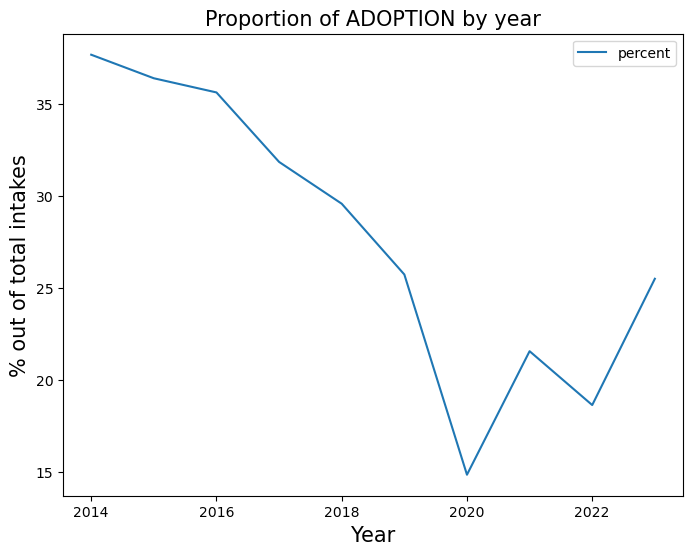

In [96]:
Image(filename = 'figures/Proportion_of_ADOPTION_by_Year.png', width=600, height=600)

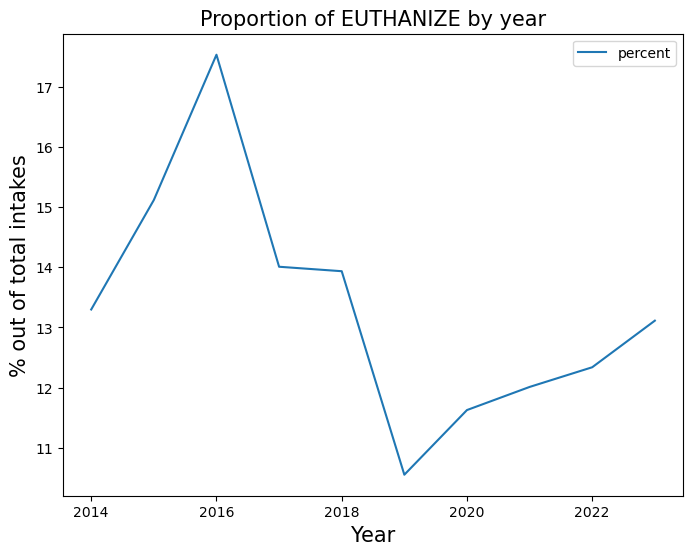

In [97]:
Image(filename = 'figures/Proportion_of_EUTHANIZE_by_Year.png', width=600, height=600)

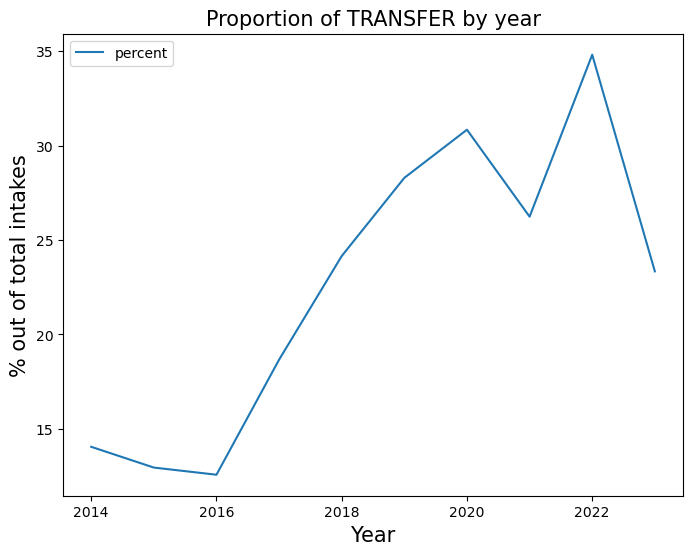

In [98]:
Image(filename = 'figures/Proportion_of_TRANSFER_by_Year.png', width=600, height=600)

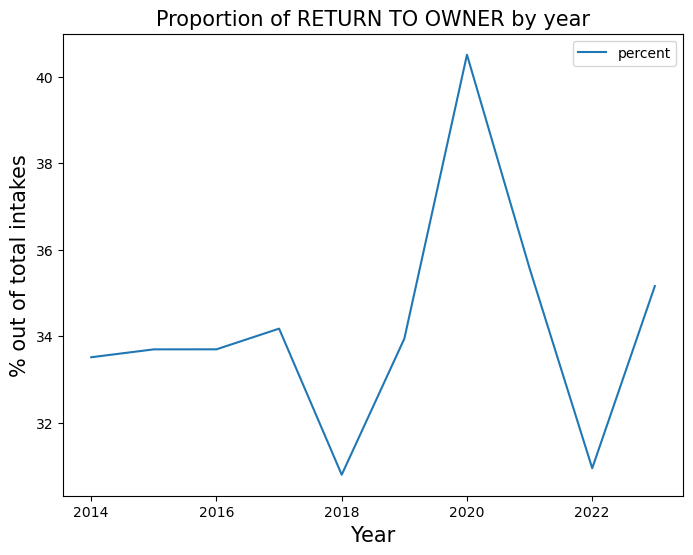

In [99]:
Image(filename = 'figures/Proportion_of_RETURN TO OWNER_by_Year.png', width=600, height=600)

It appears that as the adoption rate declines throughout the years, the shelter chooses to transfer than animals rather than euthanizing. 

## Modeling

### Will this Animal be Adopted?

In [57]:
shelter_data.rename(columns={'Intake Subtype': 'Intake_Subtype',
                            'Intake Type': 'Intake_Type',
                            'Intake Condition': 'Intake_Condition'}, inplace=True)

In [58]:
# Create a new column named Adopted, and assign a value of 0 or 1 
# to indicate whether each animal has been adopted or not.
shelter_data['Adopted'] = (shelter_data['Outcome Type'] == 'ADOPTION').astype(int)

#Split the data into test and train
shelter_train, shelter_test = train_test_split(shelter_data, test_size=0.3, random_state=159)
shelter_train.shape, shelter_test.shape

((17481, 26), (7492, 26))

In [59]:
import statsmodels.formula.api as smf
logreg = smf.logit(formula = 'Adopted ~ Type + Sex + Size + Intake_Type + Intake_Condition',
                       data = shelter_train).fit()
print(logreg.summary())

         Current function value: 0.357273
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Adopted   No. Observations:                17481
Model:                          Logit   Df Residuals:                    17457
Method:                           MLE   Df Model:                           23
Date:                Tue, 09 May 2023   Pseudo R-squ.:                  0.4094
Time:                        23:36:35   Log-Likelihood:                -6245.5
converged:                      False   LL-Null:                       -10575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.2155      0.201     -1.072      0.284

/srv/conda/envs/notebook/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
# Predicting the probability of adopted
y_prob = logreg.predict(shelter_test)

# Predicting the label: 0 or 1?
y_pred = pd.Series([1 if x > 1/2 else 0 for x in y_prob], index=y_prob.index)

from sklearn.metrics import confusion_matrix
y_test = shelter_test['Adopted']
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[4820  460]
 [ 809 1403]]


In [61]:
TN, FP, FN, TP = cm.ravel()

# What is the Accuracy?
acc= (TN + TP) / sum(cm.ravel())
print('Accuracy is: %.4f' %acc)


# What is the True Positive Rate ?
TPR_logit = TP/(TP+FN)
print('TPR is: %.4f' % TPR_logit)

# What is the False Positive rate ?
FPR_logit = FP/(FP+TN)
print('FPR is: %.4f' % FPR_logit)

Accuracy is: 0.8306
TPR is: 0.6343
FPR is: 0.0871


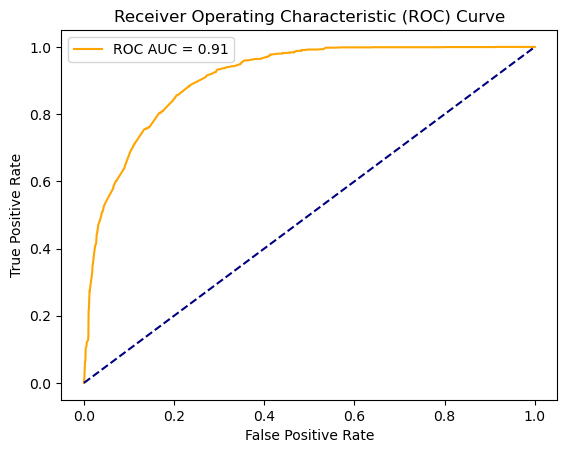

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, color='orange', label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

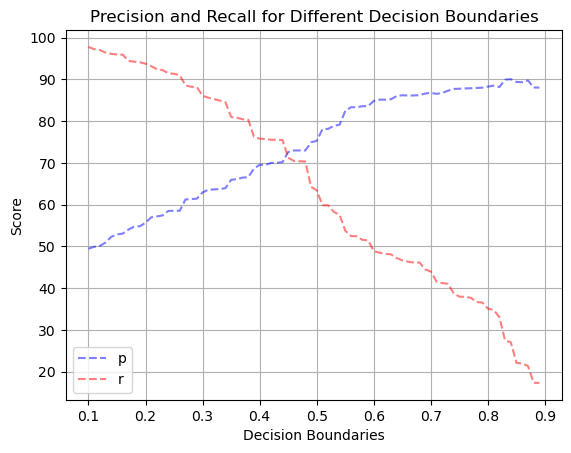

In [63]:
from sklearn.metrics import precision_score, recall_score

boundary_precisions = []
boundary_recalls = []
                       
for b in np.arange (0.1, 0.9, 0.01) :
    boundary_predictions = (y_prob >= b).astype(int)
    boundary_precisions.append(precision_score(y_test, boundary_predictions) * 100)
    boundary_recalls.append(recall_score(y_test, boundary_predictions) * 100)
    
plt.plot(np.arange(0.1, 0.9, 0.01), boundary_precisions, color='blue', linestyle='--', alpha=0.5, label='p')

plt.plot(np.arange(0.1, 0.9, 0.01), boundary_recalls, color='red', linestyle='--', alpha=0.5, label='r')


plt.xlabel('Decision Boundaries')
plt.ylabel('Score')
plt.title( 'Precision and Recall for Different Decision Boundaries')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### How Many Days Before Adoption?

In [64]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']

### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake_Type', 'Intake_Subtype', 'Intake_Condition', 'Intake Jurisdiction', 'Location',
                      'Intake Year']]
adopted = adopted.reset_index(drop=True)

### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')

In [65]:
adopted_all.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake_Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count', 'Intake Year', 'Adopted'],
      dtype='object')

In [66]:
adopted['log_days'] = np.log1p(adopted['Days in Shelter'])

In [67]:
adopted_filtered = adopted[adopted['Days in Shelter']< 200]

In [68]:
!pip install catboost -q

In [69]:
### test train split
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(adopted_filtered.drop(['Days in Shelter', 'log_days'], axis=1), 
                                                    adopted_filtered['log_days'], test_size=0.2, random_state=42)

In [72]:
import pickle

# Load the model
with open('model_results/' + 'CatBoostRegressor.pickle', 'rb') as f:
    model = pickle.load(f)

# Load the predictions
with open('model_results/' + 'CatPredictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

# Load the fitted results
with open('model_results/' + 'CatFittedResult.pickle', 'rb') as f:
    fitted_results = pickle.load(f)

In [73]:
# model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], loss_function='MAE', verbose=500,
#                          depth=9, iterations=1500, learning_rate=0.05)
model.fit(X_train, y_train)
# predictions = model.predict(X_test)

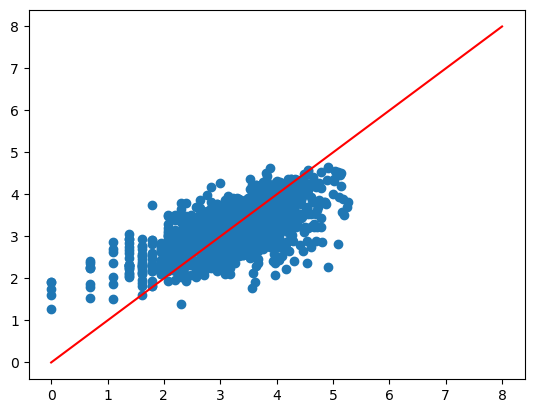

In [75]:
x = np.linspace(0, 8, 100)
y = x

plt.plot(x, y, color='red');
plt.scatter(x=y_test, y=predictions);
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

unlog_pred = np.expm1(predictions)
unlog_actual = np.expm1(y_test)

rmse = mean_squared_error(unlog_actual, unlog_pred, squared=False)
r2 = r2_score(y_test, predictions)

print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 22.60
R2: 0.48


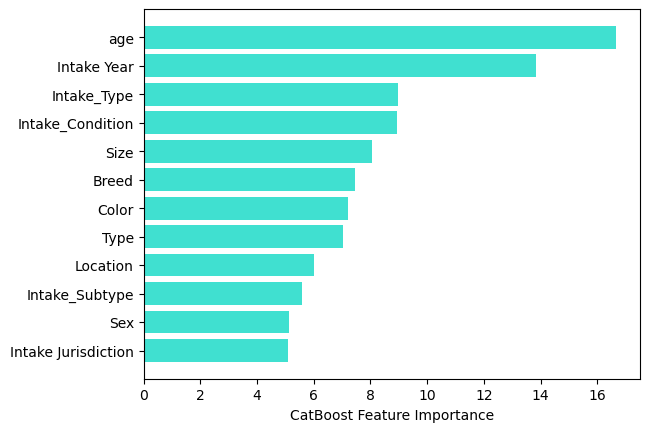

In [77]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance");

## Conclusions

Our model predicting whether or not an animal will be adopted performed adequately. It achieved an accuracy of 83%, true positive rate of 63%, and a 9% false positive rate when using a standard 0.5 decision boundary. The ROC-AUC score was 0.91. When plotting the precision and recall rates using different decision boundaries, both lines intersected around 72%

Our model predicting the number of days before adoption did not perform very well. We transformed the target values as it followed an exponential distribution, but the model still did not perform very well. The RMSE was 22.6 days, and the R squared value was quite low, at 0.36.

But the feature importances for the CatBoost were help. It tells us that Age and Intake yere were the top 2 most important features when performing the regression.

## Author Contributions